In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:

import numpy as np
import pandas as pd
import os
import keras
from sklearn.datasets import load_files
from keras.utils import np_utils


from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,Input
# from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.models import Sequential,Model
from keras import backend as K
from IPython.display import display

from keras.preprocessing.image import ImageDataGenerator

import glob
import cv2
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense , Dropout,Activation
from keras import layers, optimizers
import tensorflow as tf
from keras import applications

Using TensorFlow backend.


In [0]:
train_datagen = ImageDataGenerator( rescale=1./255,
      rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      shear_range=0.2,
      #zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.35)

test_datagen=ImageDataGenerator(rescale=1./255)

In [6]:
batch_size=128
img_rows=224
img_cols=224

training_set = train_datagen.flow_from_directory("/content/gdrive/My Drive/Image_Sorter/SortedImages", 
                                                 target_size = (img_rows,img_cols), 
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 subset="training")

test_set = train_datagen.flow_from_directory("/content/gdrive/My Drive/Image_Sorter/SortedImages", 
                                                 target_size = (img_rows,img_cols),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 subset='validation')


Found 6520 images belonging to 7 classes.
Found 3505 images belonging to 7 classes.


In [15]:

#model = applications.VGG16(weights=None, include_top=False,
 #                          input_shape=(img_rows, img_cols, 3))




""""top_model = Sequential()
top_model.add(Flatten())
top_model.add(Dense(1096,activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(7,activation='softmax'))


"""

from keras.applications.resnet50 import ResNet50

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

visible = Input(shape=(img_rows,img_cols,3))                    #////INPUT
''''#visible1 = Input(shape=(img_rows,img_cols,3))                    

p_layer1 = ResNet50(weights=None,include_top=False,input_shape=(img_rows,img_cols,3))(visible)
flat1= Flatten()(p_layer1)


p_layer2 = applications.Xception(weights=None,include_top=False,input_shape=(img_rows, img_cols, 3))(visible)
flat2= Flatten()(p_layer2)

merge =concatenate([flat1,flat2])              #//// MERGE

hidden=Dense(4096,activation='relu')(merge)   # //// INTERPRETATION LAYER
#hidden=Dropout(0.5)(hidden)
hidden=Dense(4096,activation='relu')(hidden)
#hidden=Dropout(0.5)(hidden)
hidden=Dense(1000,activation='relu')(hidden)
#hidden=Dropout(0.45)(hidden)
output=Dense(7,activation='softmax')(hidden)          # /// PREDICTION LAYER


base_model = keras.applications.resnet50.ResNet50(include_top=False,weights=None,input_shape=(img_rows,img_cols,3))

top_model = Sequential()
top_model.add(Flatten())

top_model.add(Dense(7,activation='softmax'))

model = Model(inputs=[base_model.input], outputs=top_model(base_model.output))
'''
mobile = keras.applications.mobilenet.MobileNet()

# See a summary of the layers in the model


# Modify the model
# Exclude the last 5 layers of the model
x = mobile.layers[-6].output
# Add a dropout and dense layer for predictions
x = Dropout(0.5)(x)
predictions = Dense(7,kernel_initializer='he_uniform',activation='softmax')(x)

# Create a new model with the new outputs
model = Model(inputs=mobile.input, outputs=predictions)
print('Model loaded.')

#for layer in model.layers[:-23]:
 #   layer.trainable = False



Model loaded.


In [0]:
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[categorical_accuracy,top_2_accuracy, top_3_accuracy])


from keras.utils import plot_model
#plot_model(model, to_file='fusion1.png')


In [17]:
'''class_weights={
    0: 1.5,  # akiec
    1: 1.5,  # bcc
    2: 1.5,  # bkl
    3: 1.5,  # df
    4: 4.0,  # mel
    5: 0.0,  # nv
    6: 1.5,  # vasc
}
'''

import imageio as im
from keras import models
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau




call_early=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1,
                                         mode='auto', baseline=None, restore_best_weights=False)


reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3,
                              verbose=1, mode='max', min_lr=0.00001)

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_categorical_accuracy',
                               verbose=1, 
                               save_best_only=True)

callbacks_list=[checkpointer,reduce_lr,call_early]

history=model.fit_generator(training_set,
                            steps_per_epoch = training_set.samples // batch_size,
                            validation_data = test_set, 
                            validation_steps = test_set.samples // batch_size,
                            callbacks=callbacks_list,
                            epochs =30)
                         #   class_weight=class_weights)


Instructions for updating:
Use tf.cast instead.
Epoch 1/30
50/50 [==============================] - 2851s 57s/step - loss: 0.9641 - categorical_accuracy: 0.7013 - top_2_accuracy: 0.8363 - top_3_accuracy: 0.9067 - val_loss: 1.5733 - val_categorical_accuracy: 0.7263 - val_top_2_accuracy: 0.8449 - val_top_3_accuracy: 0.9479

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72627, saving model to best_weights.hdf5
Epoch 2/30
50/50 [==============================] - 215s 4s/step - loss: 0.5586 - categorical_accuracy: 0.7967 - top_2_accuracy: 0.9238 - top_3_accuracy: 0.9715 - val_loss: 0.8730 - val_categorical_accuracy: 0.7664 - val_top_2_accuracy: 0.8836 - val_top_3_accuracy: 0.9550

Epoch 00002: val_categorical_accuracy improved from 0.72627 to 0.76636, saving model to best_weights.hdf5
Epoch 3/30
50/50 [==============================] - 222s 4s/step - loss: 0.4437 - categorical_accuracy: 0.8370 - top_2_accuracy: 0.9478 - top_3_accuracy: 0.9834 - val_loss: 1.3541 - val_categor

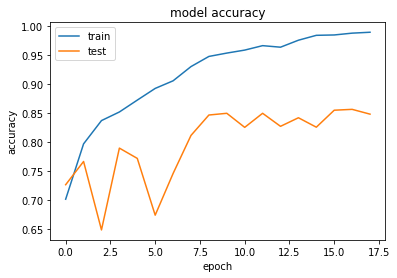

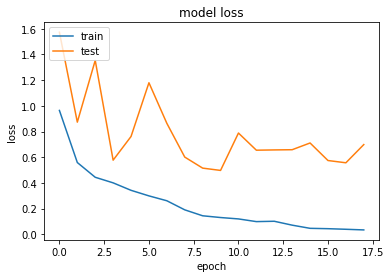

In [18]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
scores=model.evaluate_generator(training_set,steps=10)
print("training",scores)

scores1=model.evaluate_generator(test_set,steps=10)
print("test",scores1)

training [0.05447648934223367, 0.9803459100753257, 0.9992138364779874, 0.9992138364779874]
test [0.66400505900383, 0.8546875, 0.946875, 0.9890625]


In [0]:
model.save("mobile_net_he.h5")

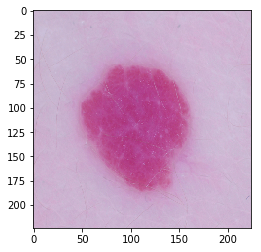

(1, 224, 224, 3)
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
Predicted class is: [5]
**********************************************************


In [23]:
layer_outputs = [layer.output for layer in model.layers[:14]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

img_path ="/content/gdrive/My Drive/Image_Sorter/SortedImages/VASC/ISIC_0027256.jpg"
img =image.load_img(img_path,target_size=(img_rows, img_cols))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)


label=(training_set.class_indices)
print(label)

# predicting images

# predicting images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=128)
print("Predicted class is:",classes.argmax(axis=-1))

print('**********************************************************')
  

In [0]:
from google.colab import files
uploaded = files.upload()

Saving images.jpeg to images.jpeg


In [0]:
img_path ="/content/gdrive/My Drive/Image_Sorter/SortedImages/VASC/ISIC_0027256.jpg"
img =image.load_img(img_path,target_size=(img_rows, img_cols))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor/=255.
activations = activation_model.predict(img_tensor) 

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='gray')


In [0]:
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

In [0]:
test_set.reset()
training_set.reset()

pred=model.predict_generator(training_set,
                             steps=training_set.samples // batch_size,
                             verbose=1)
pred = np.argmax(pred, axis=1)

pred1=model.predict_generator(test_set,
                             steps=test_set.samples // batch_size,
                             verbose=1)
pred1 = np.argmax(pred1, axis=1)


54/54 [==============================] - 87s 2s/step


In [0]:
from sklearn.metrics import classification_report
print(classification_report(test_set.classes[0:3456], pred1,target_names=test_set.class_indices))
print('******************************************************************')
print('training report')
print(classification_report(training_set.classes[0:6464], pred,target_names=training_set.class_indices))

              precision    recall  f1-score   support

       AKIEC       0.04      0.03      0.03       114
         BCC       0.03      0.03      0.03       179
         BKL       0.10      0.07      0.08       388
          DF       0.00      0.00      0.00        40
         MEL       0.12      0.08      0.10       389
          NV       0.67      0.73      0.70      2346
        VASC       0.00      0.00      0.00         0

   micro avg       0.52      0.52      0.52      3456
   macro avg       0.14      0.14      0.14      3456
weighted avg       0.48      0.52      0.50      3456

******************************************************************
training report
              precision    recall  f1-score   support

       AKIEC       0.01      0.01      0.01       213
         BCC       0.05      0.05      0.05       335
         BKL       0.13      0.12      0.12       721
          DF       0.01      0.01      0.01        75
         MEL       0.12      0.10      0.11      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
from sklearn.metrics import roc_curve
pred=model.predict_generator(test_set,steps=training_set.samples // batch_size)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_set, pred)